# SQL Datenbank erstellen


---

Datenset: Synthea Breast Cancer Dataset https://github.com/Fuenfgeld/DMA2023TeamA/tree/main/Data/Data

Primär- und Fremdschlüsseldefinitionen aus dem Synthea Repository: https://github.com/synthetichealth/synthea/wiki/CSV-File-Data-Dictionary

Projektgruppe Repository: https://github.com/Fuenfgeld/DMA2023TeamA

Mithilfe dieses Colab-Books wird eine Datenbank erstellt, in welche dann die synthetischen Daten des breast cancer datasets geladen werden. Die Datenbank dient im weiteren Projektverlauf als Grundlage für Analysen und Programmieraufgaben. 







Version: 1.0

Version Date: 21/01/2023

In [ ]:
# Vorsichtshalber: Löschen aller Variablen
%reset -f

# Laden der benötigten Libraries
from google.colab import drive
import sqlite3 as sq
from sqlite3 import Error
import pandas as pd
import os
import csv

Mounten des Google Drives, überprüfen der Ordner im Shareddrive, in welchem die Rohdaten und die Datenbank selbst liegt. 
Außerdem setzen von Pfadangaben, die im späteren Code benötigt werden:


1.   Festlegen des Pfads zu den Rohdaten
2.   Festlegen des Pfads zur Datenbank



In [ ]:
# Google Drive mounten, force_remount auf True setzen, damit ein Remount erzwungen wird
drive.mount('/content/gdrive/', force_remount=True)

# Database Folder auf dem Shareddrive checken
!ls "/content/gdrive/Shareddrives/DMA_Datenprojekt_TeamA/Database"

# Rohdaten Ordner checken
!ls "/content/gdrive/Shareddrives/DMA_Datenprojekt_TeamA/SourceData"

# Patiententyp festlegen
patient_type = "breast_cancer"

# Pfad zu Datenbank setzen
DB_FILE_PATH = "/content/gdrive/Shareddrives/DMA_Datenprojekt_TeamA/Database/source_breast_cancer.db"

# Pfad zu den csv-Dateien setzen
csv_path = "/content/gdrive/Shareddrives/DMA_Datenprojekt_TeamA/SourceData/"

# Check
print("\n" + DB_FILE_PATH)

print(csv_path)

## Anlegen der SQL-CREATE TABLE-Statements

Anlegen der Key - Value - Kombinationen für ein Dictionary, in welchem alle SQL-CREATE TABLE-Statements stehen. 
Spalten, Datentypen, Constraints, sowie Schlüsselbedingungen (Fremd- und Primärschlüssel) wurden ahand der Dokumentation im Synthea-Repostiroy: https://github.com/synthetichealth/synthea/wiki/CSV-File-Data-Dictionary gesetzt. 

Nach Sichtung aller nötigen csv-Tabellen wurden die Datentypen entsprechend des Inhalts der Spalten gewählt. Außerdem wurden in der Synthea-Dokumentation enthaltene Spalten, welche kein Äquivalent in den csv-Daten haben, entfernt. Eine vollständige Dokumentation der Tabellen und, welche spalten entfernt wurden, können Sie unter https://github.com/Fuenfgeld/DMA2023TeamA/wiki finden.




Dictionary anlegen. Key = Name der Tabelle die angelegt werden soll, Value = SQL-String für den Insert-Befehl. 


In [ ]:
sql_table = {}

CREATE-Table Strings erstellen. 

In [ ]:
# Tabelle Patienten
sql_table["patients"] = """CREATE TABLE IF NOT EXISTS patients (
                           Id VARCHAR PRIMARY KEY,
                           BIRTHDATE DATE,
                           DEATHDATE DATE,
                           SSN VARCHAR,
                           DRIVERS VARCHAR,
                           PASSPORT VARCHAR,
                           PREFIX VARCHAR,
                           FIRST VARCHAR,
                           LAST VARCHAR,
                           SUFFIX VARCHAR,
                           MAIDEN VARCHAR,
                           MARITAL CHAR(1),
                           RACE VARCHAR,
                           ETHNICITY VARCHAR,
                           GENDER CHAR(1),
                           BIRTHPLACE VARCHAR,
                           ADDRESS VARCHAR,
                           CITY VARCHAR,
                           STATE VARCHAR,
                           COUNTRY VARCHAR,
                           ZIP VARCHAR,
                           LAT FLOAT,
                           LON FLOAT,
                           HEALTHCARE_EXPENSES FLOAT,
                           HEALTHCARE_COVERAGE FLOAT);"""

# Check Dictionary Keys
print(sql_table.keys())

In [ ]:
# Tabelle payer_transitions
sql_table["payer_transitions"] = """CREATE TABLE IF NOT EXISTS payer_transitions (
                                  PATIENT VARCHAR,
                                  START_YEAR DATE,
                                  END_YEAR DATE,
                                  PAYER VARCHAR,
                                  OWNERSHIP VARCHAR,
                                  FOREIGN KEY (PATIENT)
                                    REFERENCES patients (Id)
                                  FOREIGN KEY (PAYER)
                                    REFERENCES payers (Id)
                                  );"""

# Check Dictionary Keys
print(sql_table.keys())

In [ ]:
# Tabelle payers
sql_table["payers"] = """CREATE TABLE IF NOT EXISTS payers (
                      Id VARCHAR PRIMARY KEY,
                      NAME VARCHAR,
                      ADDRESS VARCHAR,
                      CITY VARCHAR,
                      STATE_HEADQUATERED VARCHAR,
                      ZIP VARCHAR,
                      PHONE VARCHAR,
                      AMOUNT_COVERED FLOAT,
                      ANOUNT_UNCOVERED FLOAT,
                      REVENUE INTEGER,
                      COVERED_ENCOUNTERS INTEGER,
                      UNCOVERED_ENCOUNTERS INTEGER,
                      COVERED_MEDICATIONS INTEGER,
                      UNCOVERED_MEDIACTIONS INTEGER,
                      COVERED_PROCEDURES INTEGER,
                      UNCOVERED_PROCEDURES INTEGER,
                      COVERED_IMMUNIZATIONS INTEGER,
                      UNCOVERED_IMMUNIZATIONS INTEGER,
                      UNIQUE_CUSTOMERS INTEGER,
                      QOLS_AVG FLOAT,
                      MEMBER_MONTHS INTEGER
                      );"""

# Check Dictionary Keys
print(sql_table.keys())

In [ ]:
# Tabelle procedures
sql_table["procedures"]= """CREATE TABLE IF NOT EXISTS procedures (
                           DATE DATETIME,
                           PATIENT VARCHAR,
                           ENCOUNTER VARCHAR,
                           CODE INTEGER,
                           DESCRIPTION VARCHAR,
                           BASE_COST FLOAT,
                           REASONCODE VARCHAR,
                           REASONDESCRIPTION VARCHAR,
                           FOREIGN KEY (PATIENT)
                             REFERENCES patients (Id) 
                           FOREIGN KEY (Encounter)
                             REFERENCES encounters (Id) 
                           );"""

# Check Dictionary Keys
print(sql_table.keys())

In [ ]:
# Tabelle encounters
sql_table["encounters"] = """CREATE TABLE IF NOT EXISTS encounters (
                           Id Varchar PRIMARY KEY,
                           START DATETIME,
                           STOP DATETIME,
                           PATIENT VARCHAR,
                           ORGANIZATION VARCHAR,
                           PROVIDER VARCHAR,
                           PAYER VARCHAR,
                           ENCOUNTERCLASS VARCHAR,
                           CODE INTEGER,
                           DESCRIPTION VARCHAR,
                           BASE_ENCOUNTER_COST FLOAT,
                           TOTAL_CLAIM_COST FLOAT,
                           PAYER_COVERAGE FLOAT,
                           REASONCODE INTEGER,
                           REASONDESCRIPTION VARCHAR,
                           FOREIGN KEY (PATIENT)
                             REFERENCES patients (Id)
                           FOREIGN KEY (PAYER)
                             REFERENCES payers (Id)
                           );"""

# Check Dictionary Keys
print(sql_table.keys())

In [ ]:
# Tabelle Conditions

sql_table["conditions"] = """CREATE TABLE IF NOT EXISTS conditions (
                           START DATE,
                           STOP DATE,
                           PATIENT VARCHAR,
                           ENCOUNTER VARCHAR,
                           CODE INTEGER,
                           DESCRIPTION VARCHAR,
                           FOREIGN KEY (PATIENT)
                              REFERENCES patients (Id) 
                           FOREIGN KEY (Encounter)
                              REFERENCES encounters (Id) 
                           );"""

# Check Dictionary Keys
print(sql_table.keys())

### ER-Diagramm zur Illustration der Tabellenbeziehungen

Die Tabellenbeziehungen können dem nachfolgend eingefügten ER-Diagramm entnommen werden. 
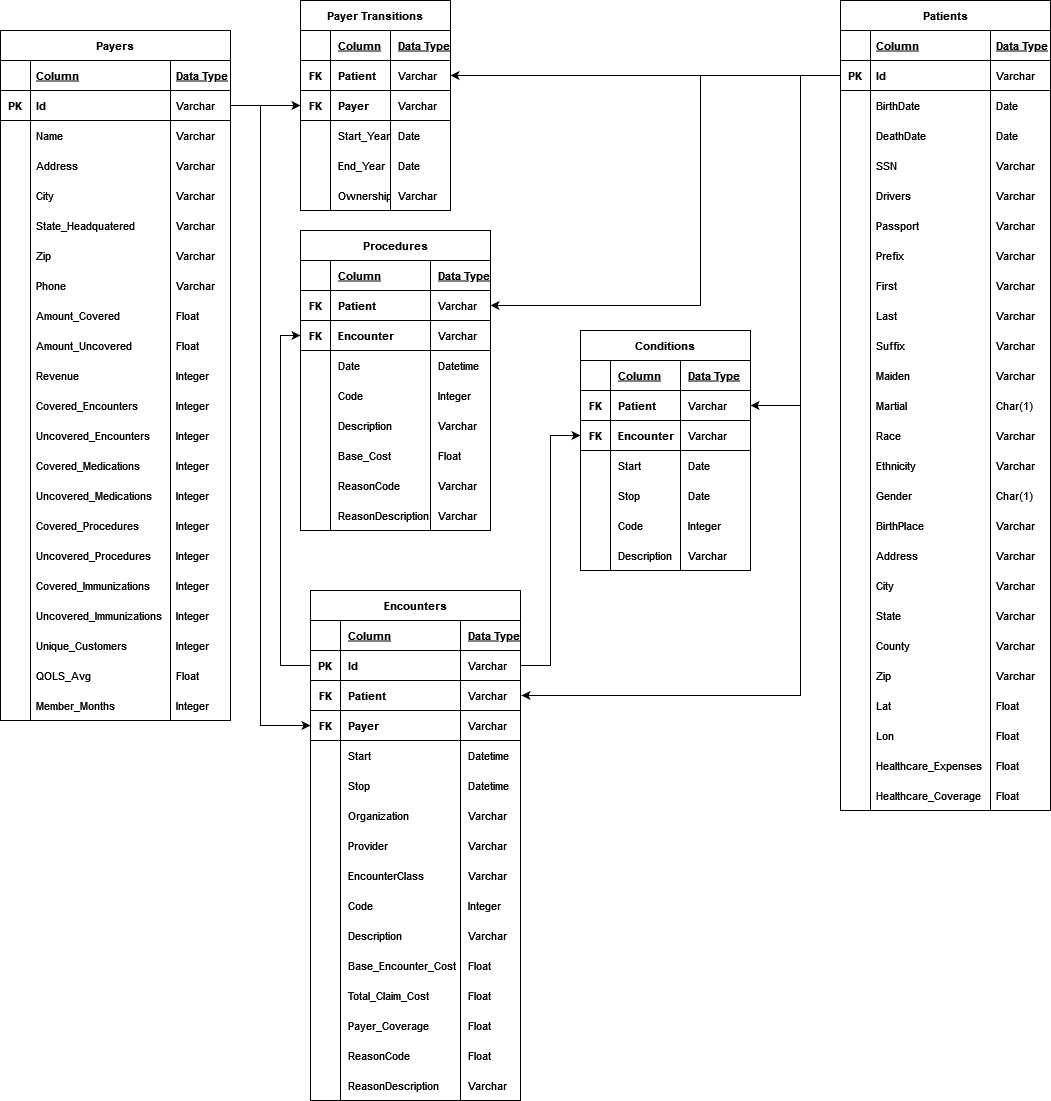

## Definition der Funktionen für den Import der synthetischen Daten

Funktionen für den Datenimport der Synthetischen Daten in die Datenbank finden Sie im Folgenden. 

In [ ]:
def connect_to_db(db_file):

    # Variable für die SQLite-Verbindung setzen
    sqlite3_conn = None

    try:
        # db_file = Parameter der Funktion, nimmt später den Pfad zur DB als Argument beim Funktionsaufruf entgegen
        sqlite3_conn = sq.connect(db_file)

        # Nach Verbindung zur DB: Rückgabe der Verbindungs-Variable
        return sqlite3_conn

    except Error as err:
        print(err)

        if sqlite3_conn is not None:
            sqlite3_conn.close()


def insert_values_to_table(cursor, table_name, csv_file_path):

    # csv-Inhalt mit der Funktion open_csv_file einlesen 
    # csv_file_path wurde in https://colab.research.google.com/drive/1wVuOwvYmoFLNhWFey-3isp9MP6cUChf_#scrollTo=lqNp5JZC579C&line=17&uniqifier=1 gesetzt
    values_to_insert = open_csv_file(csv_file_path)

    # Einfügen in Tabelle mit ensprechendem table_name in der Datenbank
    if len(values_to_insert) > 0:
        # Funktion get_coulumn_names_from_db_table liest die Spaltennamen jeder Tabelle aus
        # Column_names werden als comma separated string von get_column_names_from_db_table zurückgegeben, column_numbers als integer
        column_names, column_numbers = get_column_names_from_db_table(cursor, table_name)

        values_str = '?,' * column_numbers
        # print("*****", values_str, column_names, column_numbers)
        values_str = values_str[:-1]

        # Speichern es INSERT-Befehls für die Daten in einer Query-Variable
        sql_query = 'INSERT OR REPLACE INTO ' + table_name + '(' + column_names + ') VALUES (' + values_str + ')'

        # Query ausführen
        cursor.executemany(sql_query, values_to_insert)
        # conn.commit()

        print('SQL insert process finished')
    else:
        print('Nothing to insert')

        # conn.close()

    # else:
        # print('Connection to database failed')


def open_csv_file(csv_file_path):
    
    # csv-Datei im Schreib-Modus öffnen, als Objekt "csv_file" speichern
    with open(csv_file_path, 'r', encoding='utf-8') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)

        # Liste mit Daten aus der csv erstellen
        data = list()
        for row in reader:
            data.append(row)

        return data


def get_column_names_from_db_table(sql_cursor, table_name):
    
    # table_name = Parameter, welchem die Tabellennamen übergeben werden aus dem dictionary sql_table (mittels sql_table.keys())
    table_column_names = 'PRAGMA table_info(' + table_name + ');'

    # sql_cursor = SQL-Cursor, welcher erstellt wird und auf die Datenbank "zeigt", wird als Argument beim Funktionsaufruf übergeben
    sql_cursor.execute(table_column_names)

    # mittels .fetchall() die Ergebnisse der Abfrage zurückerhalten, in table_column_names speichern, mittels len() die Anzahl der Spalten auslesen und speichern
    table_column_names = sql_cursor.fetchall()
    column_count = len(table_column_names)

    # Leere Liste für die Spaltennamen
    column_names = list()

    # Für jeden Spaltennamen ein Element an die Liste anhängen
    for name in table_column_names:
        column_names.append(name[1])
    
    # Liste der Spaltennamne zurückgeben, mit Komma separiert, Anzahl der Spaltennamen zurückgeben
    return ', '.join(column_names), column_count


## Einlesen der csv-Dateien in die Datenbank

Die csv-Dateien werden in die Datenbank mittels einer Schleife und der Funktion insert_values_to_table (siehe https://colab.research.google.com/drive/1wVuOwvYmoFLNhWFey-3isp9MP6cUChf_#scrollTo=K3RYj3EBbEaH&line=3&uniqifier=1) sukzessive in die Datenbank geladen.

In [ ]:
# csv-Dateien sukzessive einlesen und die Daten in die Datenbank eintragen
conn = connect_to_db(DB_FILE_PATH)
if conn is not None:
        cursor = conn.cursor()
        for name in sql_table.keys():
          csv_file = csv_path + name + ".csv"
          print(name, csv_file)
          print(sql_table[name])
          cursor.execute(sql_table[name])

          insert_values_to_table(cursor, name, csv_file)
        # conn.commit()
else:
        print('Connection to database failed')

Vorgenommene Änderungen an der Datenbank müssen noch "committed" werden.

In [ ]:
# Änderungen "commiten"
conn.commit()

### Stichprobenartiger Test des INSERT INTO-Befehls

Testeshalber kann eine Tabelle ausgelesen werden, um den Inhalt gegen die csv-Datei zu prüfen.

In [ ]:
# Daten in einer Tabelle exemplarisch checken
cursor.execute("SELECT * FROM patients;")
rows = cursor.fetchall()
df = pd.DataFrame(rows)
print(df.head(5))


## Schließen der Database-Connection

Verbindung zur DB schließen. 

In [ ]:
# Verbindung schließen
conn.close()